In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import measurements
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
from collections import deque
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import pickle
import time
from sklearn.model_selection import train_test_split
% matplotlib inline

In [25]:
eval('cv2.COLOR_BGR2YCrCb')

36

In [7]:
VEHICLES_PATH = './vehicles/vehicles/'
NONVEHICLES_PATH = './non-vehicles/non-vehicles/'
vehicle_files = [os.path.join(VEHICLES_PATH, x, y) for\
                 x in os.listdir(VEHICLES_PATH) for y in os.listdir(os.path.join(VEHICLES_PATH,x)) if y!='.DS_Store']
nonvehicle_files = [os.path.join(NONVEHICLES_PATH, x, y) for\
                 x in os.listdir(NONVEHICLES_PATH) if x!='.DS_Store'\
                    for y in os.listdir(os.path.join(NONVEHICLES_PATH,x)) if y!='.DS_Store']


X = None
y = np.array([], dtype=np.int)
for vf in vehicle_files:
    img = cv2.imread(vf)
    if X is None:
        X = img[np.newaxis]
    else:
        X = np.vstack([X,img[np.newaxis]])
    y = np.append(y, 1)
for nvf in nonvehicle_files:
    img = cv2.imread(nvf)
    X = np.vstack([X, img[np.newaxis]])
    y = np.append(y,0)

In [8]:
hard_path = './hard_negatives'
hard_files = [os.path.join(hard_path, x) for x in os.listdir(hard_path) if x.endswith('.jpg')]

for nvf in hard_files:
    img = cv2.imread(nvf)
    X = np.vstack([X, img[np.newaxis]])
    y = np.append(y,0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

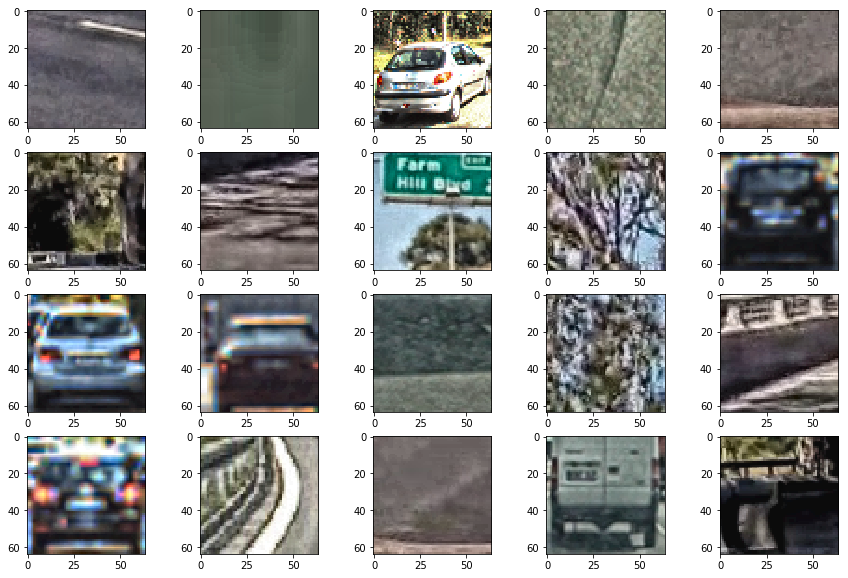

In [17]:
fig = plt.figure(figsize=(15,10))
for i in range(1,21):
    fig.add_subplot(4,5,i)
    im = X_train[i].copy()
    img = correct_histogram(im, 2.0, 8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

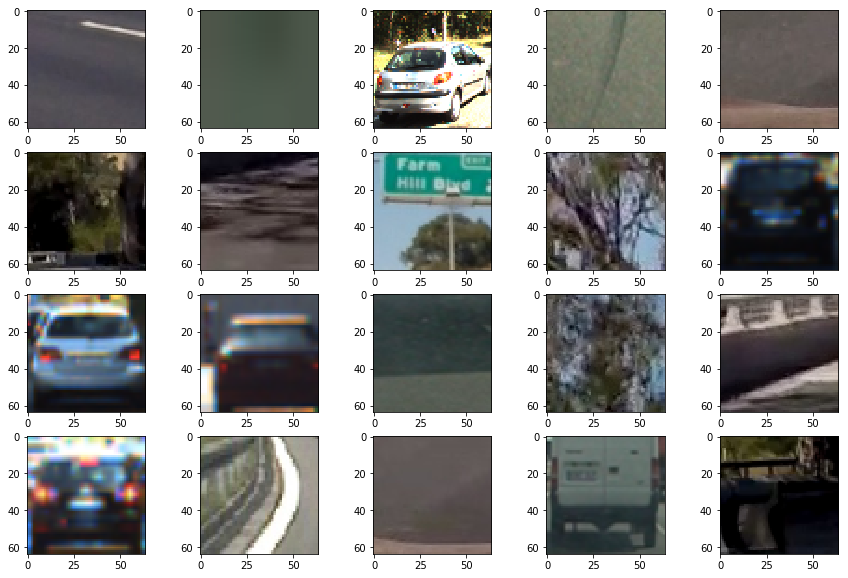

In [18]:
fig = plt.figure(figsize=(15,10))
for i in range(1,21):
    fig.add_subplot(4,5,i)
    img = X_train[i].copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

In [13]:
def correct_histogram(img_, clip_limit, tile_grid_size, init_cmap='BGR'):
        cvt_cmap = eval('cv2.COLOR_'+init_cmap+'2LAB')
        inv_cvt = eval('cv2.COLOR_LAB2'+init_cmap)
        img = cv2.cvtColor(img_, cvt_cmap)
        l, a, b = cv2.split(img)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size, tile_grid_size))
        l_c = clahe.apply(l)
        img = cv2.merge((l_c, a, b))
        img = cv2.cvtColor(img, inv_cvt)
        return img

In [30]:
def gen_random_samples(imgs, n_samples, saving_path, winsize=64):
    n_per_img = math.ceil(n_samples/imgs.shape[0])
    im_shape = imgs.shape
    max_y = im_shape[1] - winsize
    max_x = im_shape[2] - winsize
    cntr = 0
    print('samples per image: %f' % n_per_img)
    for img in imgs:
        ys = np.random.randint(0, high=max_y, size=n_per_img)
        xs = np.random.randint(0, high=max_x, size = n_per_img)
        for y,x in zip(ys, xs):
            win_img = img[y:y+winsize, x:x+winsize, :]
            cntr += 1
            fname = str(cntr) + '.jpg'
            cv2.imwrite(os.path.join(saving_path, fname), win_img)
    